# Toronto Neighborhoods - Segmenting and Clustering

Here we will try to cluster Toronto neighborhoods based on the venues they offer, which we will find through a call to the foursquare API

In [124]:
import pandas as pd
import numpy as np
#! conda install -c conda-forge folium --yes
import folium
import json
from sklearn.cluster import KMeans
import requests
import matplotlib.pyplot as plt

We start by recovering the dataframe from the past notebooks, with the neighborhoods and their coordinates.

In [7]:
df = pd.read_csv('toronto_latlon.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


In [91]:
df.shape

(103, 5)

Let's build a map of Toronto with its Boroughs and Neighborhoods

In [187]:
tor_lat = 43.651070
tor_long = -79.347015
map_toronto = folium.Map(location=[tor_lat, tor_long], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

With this we can set up the API call. (Details omitted for safety)

In [8]:
CLIENT_ID = '###'
CLIENT_SECRET = '###'
version = '20200401'
lim = 50

Create a function to iterate all the rows on our dataframe and get the nearby venues. We store them in a dataframe for later use. 

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            version, 
            lat, 
            lng, 
            radius, 
            lim)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
toronto_venues = getNearbyVenues(df['Neighborhood'], df['Latitude'], df['Longitude'])
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


How many unique categories?

In [190]:
print('There are {} unique categories in Toronto.'.format(toronto_venues['Venue Category'].nunique()))

There are 269 unique categories in Toronto.


In [57]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood , Long Branch",10,10,10,10,10,10
"Bathurst Manor , Wilson Heights , Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
Willowdale,39,39,39,39,39,39
Woburn,4,4,4,4,4,4
Woodbine Heights,12,12,12,12,12,12


In [58]:
toronto_venues.shape

(2133, 7)

One-Hot encode the venue categories so we can cluster them later. Here we also rearrange the columns

In [69]:
toronto_df = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')
toronto_df['Neighborhood'] = toronto_venues['Neighborhood']
lcol = list(toronto_df.columns) 
lcol.remove('Neighborhood') 
fixed_columns = ['Neighborhood'] + lcol # put neighborhood as the 1st column
toronto_df = toronto_df[fixed_columns]

toronto_df.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group the dataframe by neighborhood and take the frequency of each category. This will help us cluster neighborhoods with similar venues.

In [72]:
toronto_types = toronto_df.groupby('Neighborhood').mean().reset_index()
toronto_types

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood , Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor , Wilson Heights , Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park , Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0
89,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
90,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
91,"York Mills , Silver Hills",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


There are 10 less rows now compared to the original dataframe. This means that foursquare found no venues within a radius of 500m for some neighborhoods. Let's check which are those.

In [178]:
print(set(df['Neighborhood']).symmetric_difference(toronto_types['Neighborhood']))
len(set(df['Neighborhood']))

{'Weston', 'Islington Avenue', 'West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale', 'Upper Rouge', 'Willowdale , Newtonbrook'}


98

There are 5 neighborhoods with no venues nearby. However the difference was 10 rows. This is due to different postal codes for the same neighborhood, as can be seen by the number of unique neighborhoods in the original dataframe, 98. 

We are ready now to use KMeans to cluster the data. We first try some different number of clusters to check which is best. For that, we plot the sum of squared distances to the nearest centroid (using `KMeans.inertia_`) and look for the elbow, the point where the slope flattens.

In [154]:
toronto_cluster = toronto_types.drop('Neighborhood', axis=1)
dists = []
for k in range(2,12):
    kmeans = KMeans(k, random_state=0, n_init=15)
    kmeans.fit(toronto_cluster)
    dists.append(kmeans.inertia_)

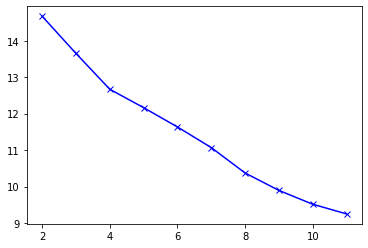

In [155]:
plt.plot(np.arange(2,12), dists, 'b-x')
plt.show()

This isn't very conclusive. There appears to be 2 elbows, one at 4 clusters and the other at 8. Further analysing shows that if we segment in 8 clusters, there are some with only one neighborhood. We therefore choose 4 clusters.

In [172]:
best_k=4
kmeans_best = KMeans(n_clusters=best_k, random_state=1, n_init=15)
kmeans_best.fit(toronto_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

Before setting up the map, we quickly check which are the most common venues per neighborhood

In [173]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [174]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = toronto_types['Neighborhood']

for ind in np.arange(toronto_types.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_types.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Clothing Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood , Long Branch",Pizza Place,Pub,Pharmacy,Sandwich Place,Athletics & Sports,Pool,Skating Rink,Coffee Shop,Gym,Colombian Restaurant
2,"Bathurst Manor , Wilson Heights , Downsview North",Coffee Shop,Bank,Supermarket,Pharmacy,Restaurant,Fried Chicken Joint,Ice Cream Shop,Diner,Middle Eastern Restaurant,Pizza Place
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park , Lawrence Manor East",Italian Restaurant,Restaurant,Sandwich Place,Coffee Shop,Juice Bar,Hobby Shop,Thai Restaurant,Sushi Restaurant,Pizza Place,Pharmacy


And finally we insert the labels into the dataframe, together with the Longitude and Latitude of the neighborhood to plot the map.

In [175]:
venues_sorted.insert(0, 'Cluster Labels', kmeans_best.labels_)
toronto_final = df.merge(venues_sorted, on='Neighborhood', how='inner')

In [170]:
toronto_final

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3,Park,Food & Drink Shop,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,French Restaurant,Intersection,Coffee Shop,Portuguese Restaurant,Hockey Arena,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Pub,Bakery,Theater,Café,Breakfast Spot,Performing Arts Venue,Farmers Market,Playground
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,1,Furniture / Home Store,Clothing Store,Women's Store,Boutique,Gift Shop,Event Space,Miscellaneous Shop,Coffee Shop,Accessories Store,Vietnamese Restaurant
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,Mexican Restaurant,Bar,Beer Bar,Sandwich Place,Burrito Place,Café,Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North",43.653654,-79.506944,3,Park,Pool,River,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
94,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Yoga Studio,Men's Store,Gastropub,Gay Bar,Mediterranean Restaurant,Grocery Store
95,M7Y,East Toronto,Business reply mail Processing Centre,43.662744,-79.321558,1,Light Rail Station,Garden,Smoke Shop,Brewery,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Auto Workshop
96,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,...",43.636258,-79.498509,1,Home Service,Breakfast Spot,Baseball Field,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


In [176]:
from matplotlib import cm
from matplotlib.cm import colors


map_clusters = folium.Map(location=[tor_lat, tor_long], zoom_start=11)

x = np.arange(kclust)
ys = [i + x + (i*x)**2 for i in range(best_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_final['Latitude'], toronto_final['Longitude'], toronto_final['Neighborhood'], toronto_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We see here that cluster 2 has only one neighborhood, Roselawn. Let's check what is different about it.

In [183]:
venues_sorted.loc[venues_sorted['Neighborhood'] == 'Roselawn']

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
66,2,Roselawn,Garden,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega


In [181]:
venues_sorted.loc[venues_sorted['Neighborhood'] == 'Westmount']

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,0,Westmount,Pizza Place,Chinese Restaurant,Intersection,Coffee Shop,Middle Eastern Restaurant,Sandwich Place,Discount Store,Yoga Studio,Dessert Shop,Dim Sum Restaurant


In [182]:
venues_sorted.loc[venues_sorted['Neighborhood'] == 'East Toronto']

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,3,East Toronto,Convenience Store,Park,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


In [184]:
venues_sorted.loc[venues_sorted['Neighborhood'] == 'Woodbine Heights']

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
90,1,Woodbine Heights,Skating Rink,Cosmetics Shop,Spa,Beer Store,Diner,Bus Stop,Dance Studio,Park,Curling Ice,Video Store


In [186]:
venues_sorted.groupby('Cluster Labels')['1st Most Common Venue'].value_counts()

Cluster Labels  1st Most Common Venue        
0               Pizza Place                       5
                Park                              1
1               Coffee Shop                      17
                Café                              9
                Sandwich Place                    4
                Clothing Store                    3
                Grocery Store                     3
                Fast Food Restaurant              2
                Gym                               2
                Indian Restaurant                 2
                Park                              2
                Pharmacy                          2
                Pizza Place                       2
                Rental Car Location               2
                Accessories Store                 1
                Airport Lounge                    1
                Bakery                            1
                Bank                              1
                Ba

From this, it looks like it's the only cluster where a Garden is the most frequent venue. Cluster 3 has 2 neighborhoods where convenience store is the 1st most common, however 8 neighborhoods have Park as the most common venue, which happens also for clusters 0 and 1. The separation must occur on the less frequent venues when compared to cluster 2.